# Configure Cluster Module Params

This notebook should be used as a test for ensuring correct cluster parameters before cluster processing.
Cells marked with <font color='red'>SET PARAMETERS</font> contain crucial variables that need to be set according to your specific experimental setup and data organization.
Please review and modify these variables as needed before proceeding with the analysis.

## <font color='red'>SET PARAMETERS</font>

### Fixed parameters for cluster module

- `CONFIG_FILE_PATH`: Path to a Brieflow config file used during processing. Absolute or relative to where workflows are run from.

In [1]:
CONFIG_FILE_PATH = "config/config.yml"

In [2]:
from pathlib import Path

import yaml
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from lib.shared.file_utils import get_filename
from lib.cluster.cluster_eval import plot_cell_histogram, plot_cluster_sizes
from lib.cluster.phate_leiden_clustering import (
    phate_leiden_pipeline,
    plot_phate_leiden_clusters,
)
from lib.cluster.benchmark_clusters import (
    perform_resolution_thresholding,
    calculate_pair_recall,
    calculate_group_enrichment,
)
from lib.cluster.scrape_benchmarks import (
    generate_string_pair_benchmark,
    generate_corum_group_benchmark,
    generate_msigdb_group_benchmark
)
from lib.shared.configuration_utils import CONFIG_FILE_HEADER

In [3]:
# load config file and determine root path
with open(CONFIG_FILE_PATH, "r") as config_file:
    config = yaml.safe_load(config_file)
    ROOT_FP = Path(config["all"]["root_fp"])

# load cell classes and channel combos
aggregate_combo_fp = config["aggregate"]["aggregate_combo_fp"]
aggregate_combos = pd.read_csv(aggregate_combo_fp, sep="\t")

CHANNEL_COMBOS = [combo.split("_") for combo in aggregate_combos["channel_combo"].unique()]
print(f"Channel Combos: {CHANNEL_COMBOS}")

CELL_CLASSES = list(aggregate_combos["cell_class"].unique())
print(f"Cell classes: {CELL_CLASSES}")

Channel Combos: [['DAPI', 'COXIV', 'CENPA', 'WGA'], ['DAPI', 'CENPA'], ['DAPI', 'WGA']]
Cell classes: ['interphase', 'mitotic', 'all']


## <font color='red'>SET PARAMETERS</font>

### Cluster preprocessing

- `MIN_CELL_CUTOFFS`: Minimum cells for each gene to be used in clusetering analysis. More cells per gene increases confidence, but some dataset types (ex mitotic) may have an inherently low number of cells for a particular perturbation.

In [4]:
MIN_CELL_CUTOFFS = {"mitotic": 0, "interphase": 3, "all": 3}

PERTURBATION_NAME_COL = config["aggregate"]["perturbation_name_col"]

Cell count distribution for: mitotic
Number of genes below cutoff: 0
[]


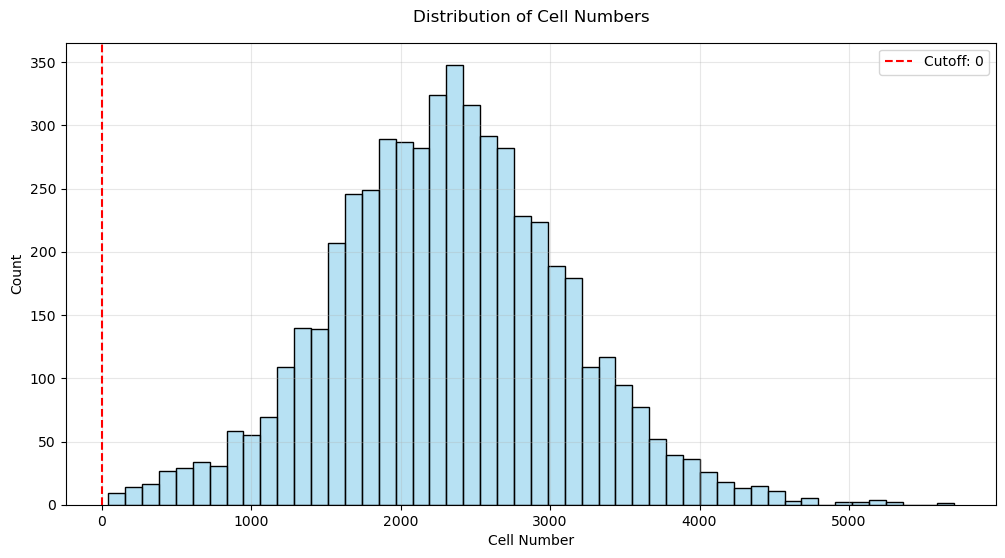

Cell count distribution for: interphase
Number of genes below cutoff: 0
[]


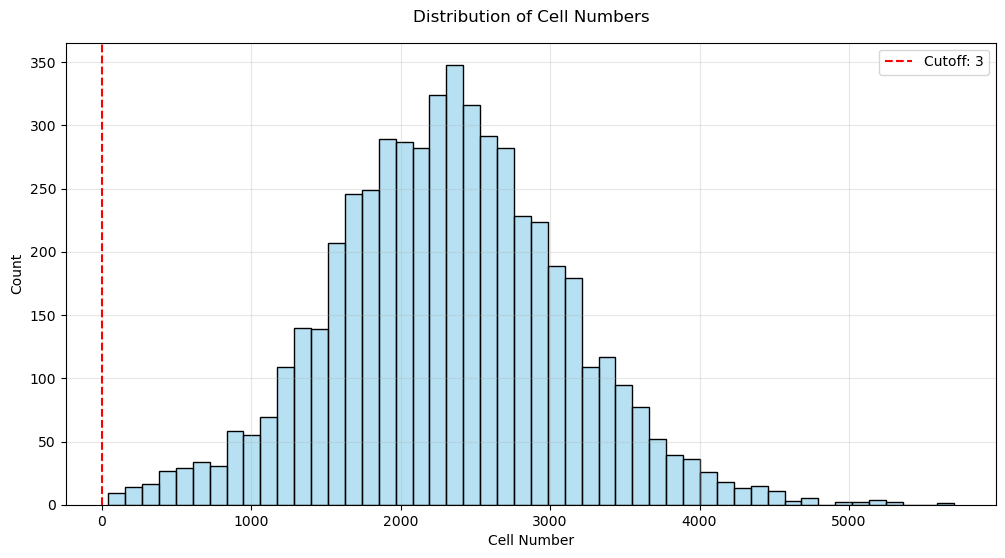

Cell count distribution for: all
Number of genes below cutoff: 0
[]


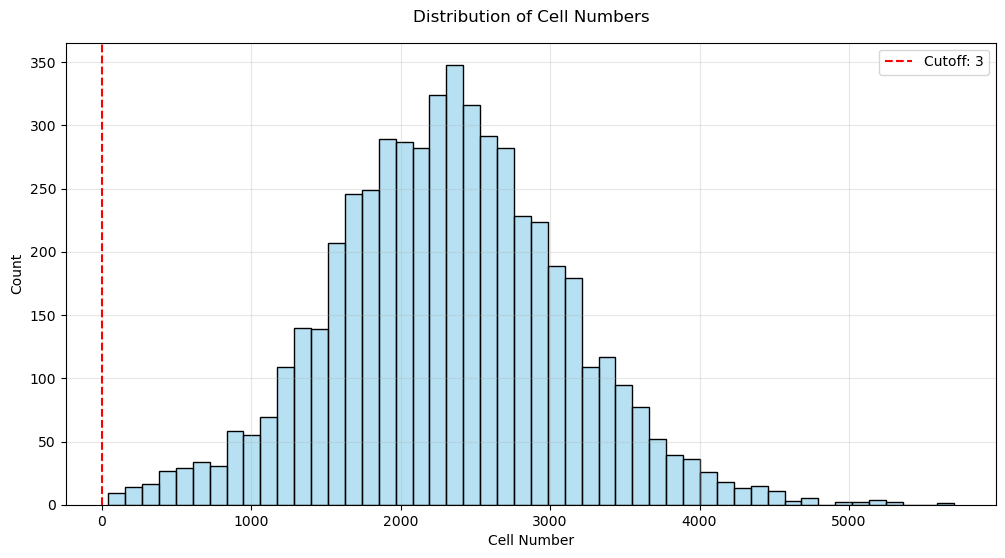

In [5]:
for cell_class, min_cell_cutoff in MIN_CELL_CUTOFFS.items():
    channel_combo = CHANNEL_COMBOS[0]
    # TODO: Use real path
    # aggregated_data_path = (
    #     ROOT_FP
    #     / "aggregate"
    #     / "tsvs"
    #     / get_filename(
    #         {"cell_class": cell_class, "channel_combo": channel_combo},
    #         "aggregated",
    #         "tsv",
    #     ),
    # )
    aggregated_data_path = "/lab/barcheese01/rkern/aggregate_overhaul/brieflow-analysis/analysis/analysis_root/aggregate_old/tsvs_99_mean/CC-interphase__aggregated.tsv"
    aggregated_data = pd.read_csv(aggregated_data_path, sep="\t")

    # show cell count distribution
    print(f"Cell count distribution for: {cell_class}")
    plot_cell_histogram(aggregated_data, min_cell_cutoff, PERTURBATION_NAME_COL)
    plt.show()

## <font color='red'>SET PARAMETERS</font>

### Benchmark Generation

- `STRING_PAIR_BENCHMARK_FP`: Path to save and access STRING pair benchmark.
- `CORUM_GROUP_BENCHMARK_FP`: Path to save and access CORUM group benchmark.
- `KEGG_GROUP_BENCHMARK_FP`: Path to save and access KEGG group benchmark.

**Note**: We use the following benchmark schemas:
- Pair Bechmark: `gene_name` column for gene matching with a cluster gene (or does not exist in cluster genes); `pair` column with a pair ID. Used to benchmark known pair relationships in generated cluster.
- Group Bechmark: `gene_name` column for gene matching with a cluster gene (or does not exist in cluster genes); `group` column with a group ID. Used to benchmark known group relationships in generated cluster, where a group represents genes involved in a pathway, protein complex, etc.

In [6]:
STRING_PAIR_BENCHMARK_FP = "config/benchmark_clusters/string_pair_benchmark.tsv"
CORUM_GROUP_BENCHMARK_FP = "config/benchmark_clusters/corum_group_benchmark.tsv"
KEGG_GROUP_BENCHMARK_FP = "config/benchmark_clusters/kegg_group_benchmark.tsv"

In [7]:
Path(STRING_PAIR_BENCHMARK_FP).parent.mkdir(parents=True, exist_ok=True)

# string_pair_benchmark = generate_string_pair_benchmark(aggregated_data, "gene_symbol_0")
# string_pair_benchmark.to_csv(STRING_PAIR_BENCHMARK_FP, sep="\t", index=False)
string_pair_benchmark = pd.read_csv(STRING_PAIR_BENCHMARK_FP, sep="\t")
display(string_pair_benchmark)

# corum_group_benchmark = generate_corum_group_benchmark()
# corum_group_benchmark.to_csv(CORUM_GROUP_BENCHMARK_FP, sep="\t", index=False)
corum_group_benchmark = pd.read_csv(CORUM_GROUP_BENCHMARK_FP, sep="\t")
display(corum_group_benchmark)

# kegg_group_benchmark = generate_msigdb_group_benchmark()
# kegg_group_benchmark.to_csv(KEGG_GROUP_BENCHMARK_FP, sep="\t", index=False)
kegg_group_benchmark = pd.read_csv(KEGG_GROUP_BENCHMARK_FP, sep="\t")
display(kegg_group_benchmark)

,gene_name_variants,pair,gene_name
0,ARF5,1,ARF5
1,RAB11FIP3 ARFO1 KIAA0665,1,RAB11FIP3
2,M6PR MPR46 MPRD,2,M6PR
3,GGA3 KIAA0154,2,GGA3
4,M6PR MPR46 MPRD,3,M6PR
...,...,...,...
225791,LYL1 BHLHA18,117116,LYL1
225792,RFX7 RFXDC2,117117,RFX7
225793,RFXANK ANKRA1 RFXB,117117,RFXANK
225794,RFX7 RFXDC2,117118,RFX7


,gene_name,group
0,BCL6,BCL6-HDAC4 complex
1,HDAC4,BCL6-HDAC4 complex
2,BCL6,BCL6-HDAC5 complex
3,HDAC5,BCL6-HDAC5 complex
4,BCL6,BCL6-HDAC7 complex
...,...,...
18335,QRFPR,HCRTR1-QRFPR complex
18336,LRP4,LRP4-SOST complex
18337,SOST,LRP4-SOST complex
18338,HCRTR2,HCRTR2-QRFPR complex


,gene_name,cluster
0,ACTB,KEGG_MEDICUS_REFERENCE_TIGHT_JUNCTION_ACTIN_SI...
1,ACTG1,KEGG_MEDICUS_REFERENCE_TIGHT_JUNCTION_ACTIN_SI...
2,ACTR2,KEGG_MEDICUS_REFERENCE_TIGHT_JUNCTION_ACTIN_SI...
3,ACTR3,KEGG_MEDICUS_REFERENCE_TIGHT_JUNCTION_ACTIN_SI...
4,ARPC1A,KEGG_MEDICUS_REFERENCE_TIGHT_JUNCTION_ACTIN_SI...
...,...,...
9657,LEF1,KEGG_MEDICUS_VARIANT_CDH1_REDUCED_EXPRESSION_T...
9658,MYC,KEGG_MEDICUS_VARIANT_CDH1_REDUCED_EXPRESSION_T...
9659,TCF7,KEGG_MEDICUS_VARIANT_CDH1_REDUCED_EXPRESSION_T...
9660,TCF7L1,KEGG_MEDICUS_VARIANT_CDH1_REDUCED_EXPRESSION_T...


## <font color='red'>SET PARAMETERS</font>

### Test Dataset

- `TEST_CELL_CLASS`: Cell class to test clustering on. Usually `all` or cell class of interest.
- `TEST_CHANNEL_COMBO`: Cell class to test clustering on. Usually `all` or cell class of interest.

### Phate/Leiden Clustering

- `PHATE_DISTANCE_METRIC`: Distance metric used by phate during dimensionality reduction. Can be `euclidean` or `cosine`. `cosine` is recommended.
- `LEIDEN_RESOLUTIONS`: Resolutions for Leiden clustering. Higher means more clusters.

In [8]:
TEST_CELL_CLASS = "interphase"
TEST_CHANNEL_COMBO = ['DAPI', 'CENPA']

PHATE_DISTANCE_METRIC = "cosine"
LEIDEN_RESOLUTIONS = [8, 10, 12]
# Can do more clusters for higher plot resolution, but each resolution takes about 1 min
# LEIDEN_RESOLUTIONS = [1, 2, 5, 10, 20, 50]

CONTROL_KEY = config["aggregate"]["control_key"]

Creating clusters for resolution: 8


/lab/barcheese01/rkern/miniconda3/envs/brieflow_agg_overhaul_env/lib/python3.11/site-packages/graphtools/graphs.py:236: UserWarning: Metric cosine not valid for `sklearn.neighbors.BallTree`. Graph instantiation may be slower than normal.
  warnings.warn(
/lab/barcheese01/rkern/miniconda3/envs/brieflow_agg_overhaul_env/lib/python3.11/site-packages/graphtools/graphs.py:236: UserWarning: Metric cosine not valid for `sklearn.neighbors.BallTree`. Graph instantiation may be slower than normal.
  warnings.warn(


Number of cluster genes found in group dataset: 3605
Number of cluster genes found in group dataset: 3605
Creating clusters for resolution: 10


/lab/barcheese01/rkern/miniconda3/envs/brieflow_agg_overhaul_env/lib/python3.11/site-packages/graphtools/graphs.py:236: UserWarning: Metric cosine not valid for `sklearn.neighbors.BallTree`. Graph instantiation may be slower than normal.
  warnings.warn(
/lab/barcheese01/rkern/miniconda3/envs/brieflow_agg_overhaul_env/lib/python3.11/site-packages/graphtools/graphs.py:236: UserWarning: Metric cosine not valid for `sklearn.neighbors.BallTree`. Graph instantiation may be slower than normal.
  warnings.warn(


Number of cluster genes found in group dataset: 3605
Number of cluster genes found in group dataset: 3605
Creating clusters for resolution: 12


/lab/barcheese01/rkern/miniconda3/envs/brieflow_agg_overhaul_env/lib/python3.11/site-packages/graphtools/graphs.py:236: UserWarning: Metric cosine not valid for `sklearn.neighbors.BallTree`. Graph instantiation may be slower than normal.
  warnings.warn(
/lab/barcheese01/rkern/miniconda3/envs/brieflow_agg_overhaul_env/lib/python3.11/site-packages/graphtools/graphs.py:236: UserWarning: Metric cosine not valid for `sklearn.neighbors.BallTree`. Graph instantiation may be slower than normal.
  warnings.warn(


Number of cluster genes found in group dataset: 3605
Number of cluster genes found in group dataset: 3605


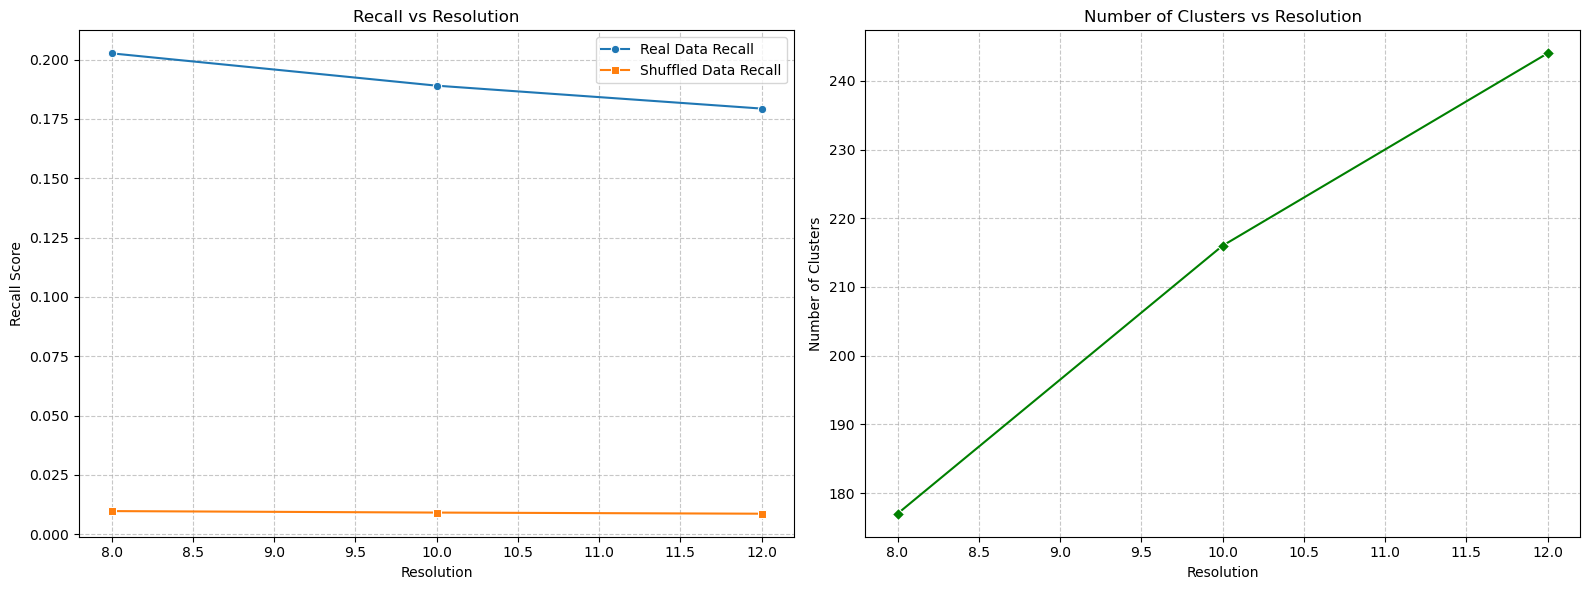

In [9]:
# TODO: Use real path
# aggregated_data_path = (
#     ROOT_FP
#     / "aggregate"
#     / "tsvs"
#     / get_filename(
#         {"cell_class": TEST_CELL_CLASS, "channel_combo": TEST_CHANNEL_COMBO},
#         "aggregated",
#         "tsv",
#     ),
# )
aggregated_data_path = "/lab/barcheese01/rkern/aggregate_overhaul/brieflow-analysis/analysis/analysis_root/aggregate_old/tsvs_99_mean/CC-interphase__aggregated.tsv"
aggregated_data = pd.read_csv(aggregated_data_path, sep="\t")

# create baseline data by shuffling columns independently
shuffled_aggregated_data = aggregated_data.copy()
feature_start_idx = shuffled_aggregated_data.columns.get_loc("PC_0")
feature_cols = shuffled_aggregated_data.columns[feature_start_idx:]
for col in feature_cols:
    shuffled_aggregated_data[col] = np.random.permutation(
        shuffled_aggregated_data[col].values
    )

# TODO: actually run this
resolution_thresholding_df, resolution_thresholding_fig = (
    perform_resolution_thresholding(
        aggregated_data,
        shuffled_aggregated_data,
        PHATE_DISTANCE_METRIC,
        LEIDEN_RESOLUTIONS,
        string_pair_benchmark,
        PERTURBATION_NAME_COL,
        CONTROL_KEY,
    )
)

## <font color='red'>SET PARAMETERS</font>

### Cluster Generation

- `TEST_LEIDEN_RESOLUTION`: Resolution for testing Leiden cluster evaluation.

In [10]:
TEST_LEIDEN_RESOLUTION = 9

/lab/barcheese01/rkern/miniconda3/envs/brieflow_agg_overhaul_env/lib/python3.11/site-packages/graphtools/graphs.py:236: UserWarning: Metric cosine not valid for `sklearn.neighbors.BallTree`. Graph instantiation may be slower than normal.
  warnings.warn(


,gene_symbol_0,cell_count,PHATE_0,PHATE_1,cluster
0,MRPS17,3045,0.005272,0.003794,0
1,LONP1,2517,0.005381,0.005029,0
2,MRPS26,1761,0.005741,0.004564,0
3,AURKAIP1,1627,0.006007,0.003984,0
4,AFG3L2,2715,0.004834,0.004620,0
...,...,...,...,...,...
5294,NHSL1,2286,0.004861,0.005114,197
5295,GFM2,2859,0.005950,0.002983,197
5296,TSEN15,3102,0.007021,0.002138,197
5297,F3,2470,0.004998,0.003097,197


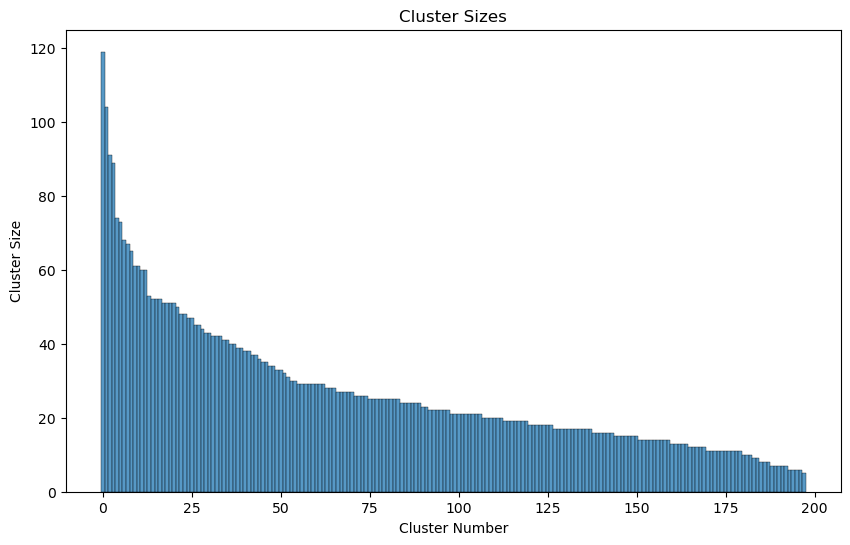

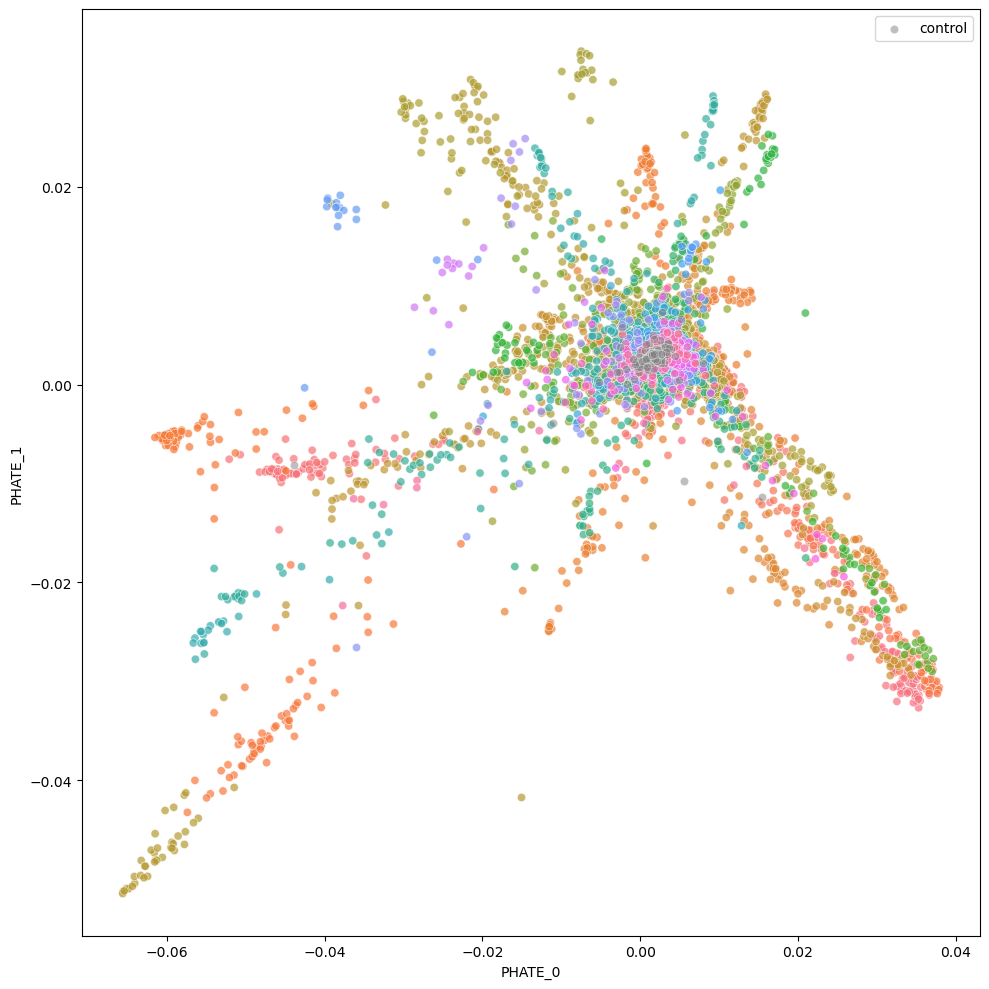

In [ ]:
phate_leiden_clustering = phate_leiden_pipeline(
    aggregated_data,
    TEST_LEIDEN_RESOLUTION,
    PHATE_DISTANCE_METRIC,
)
display(phate_leiden_clustering)

cluster_size_fig = plot_cluster_sizes(phate_leiden_clustering)
plt.show()

clusters_fig = plot_phate_leiden_clusters(
    phate_leiden_clustering, PERTURBATION_NAME_COL, CONTROL_KEY
)
plt.show()

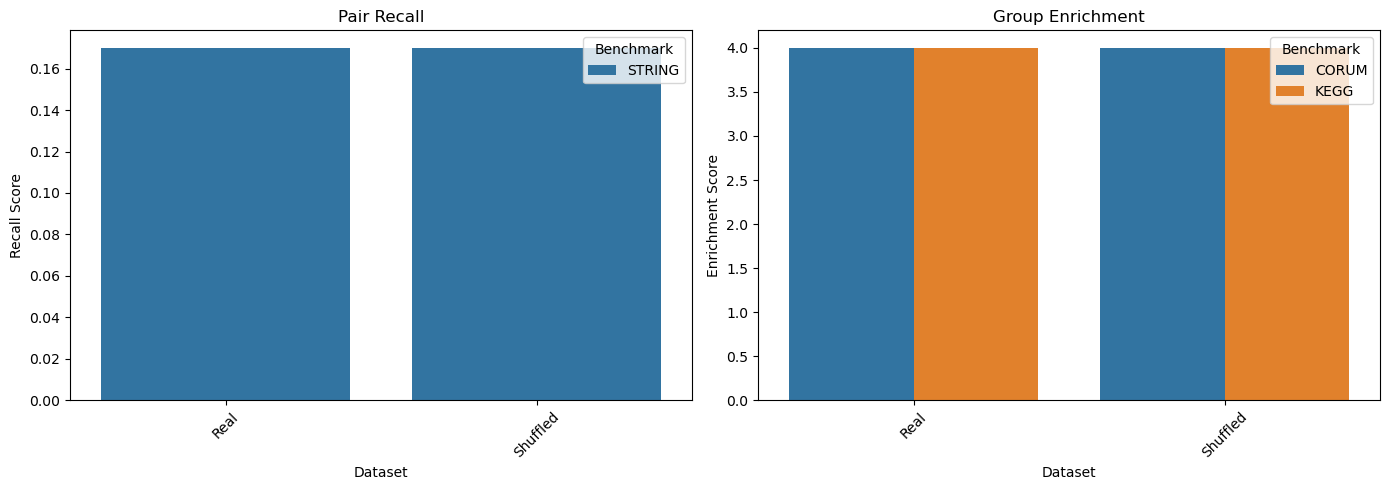

In [17]:
# phate_leiden_clustering_shuffled = phate_leiden_pipeline(
#     shuffled_aggregated_data,
#     TEST_LEIDEN_RESOLUTION,
#     PHATE_DISTANCE_METRIC
# )

cluster_datasets = {
    "Real": phate_leiden_clustering,
    "Shuffled": phate_leiden_clustering_shuffled,
}

pair_recall_benchmarks = {
    "STRING": string_pair_benchmark,
}

group_enrichment_benchmarks = {
    "CORUM": corum_group_benchmark,
    "KEGG": kegg_group_benchmark,
}

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_benchmark_results(cluster_datasets, pair_recall_benchmarks, group_enrichment_benchmarks):
    """Plot benchmark results for pair recall and group enrichment across clustering datasets.

    Args:
        cluster_datasets (dict): Mapping from dataset name to cluster DataFrame.
        pair_recall_benchmarks (dict): Mapping from benchmark name to pair benchmark DataFrame.
        group_enrichment_benchmarks (dict): Mapping from benchmark name to group benchmark DataFrame.

    Returns:
        matplotlib.figure.Figure: Figure with benchmark bar plots.
    """
    # Collect data
    pair_data = []
    for benchmark_name, benchmark_df in pair_recall_benchmarks.items():
        for dataset_name, cluster_df in cluster_datasets.items():
            # score = calculate_pair_recall(
            #     benchmark_df,
            #     cluster_df,
            #     perturbation_col_name=PERTURBATION_NAME_COL,
            #     control_key=CONTROL_KEY,
            # )
            score = 0.17  # TODO: use calculate_pair_recall
            pair_data.append({
                "Score": score,
                "Dataset": dataset_name,
                "Benchmark": benchmark_name,
                "Type": "Pair Recall"
            })

    group_data = []
    for benchmark_name, benchmark_df in group_enrichment_benchmarks.items():
        for dataset_name, cluster_df in cluster_datasets.items():
            # score = calculate_group_enrichment(
            #     benchmark_df,
            #     cluster_df,
            #     perturbation_col_name=PERTURBATION_NAME_COL,
            #     control_key=CONTROL_KEY,
            # )
            score = 4  # TODO: use calculate_group_enrichment
            group_data.append({
                "Score": score,
                "Dataset": dataset_name,
                "Benchmark": benchmark_name,
                "Type": "Group Enrichment"
            })

    df = pd.DataFrame(pair_data + group_data)

    # Plot using seaborn
    fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=False)

    sns.barplot(
        data=df[df["Type"] == "Pair Recall"],
        x="Dataset", y="Score", hue="Benchmark", ax=axes[0]
    )
    axes[0].set_title("Pair Recall")
    axes[0].set_ylabel("Recall Score")
    axes[0].tick_params(axis='x', rotation=45)

    sns.barplot(
        data=df[df["Type"] == "Group Enrichment"],
        x="Dataset", y="Score", hue="Benchmark", ax=axes[1]
    )
    axes[1].set_title("Group Enrichment")
    axes[1].set_ylabel("Enrichment Score")
    axes[1].tick_params(axis='x', rotation=45)

    fig.tight_layout()
    return fig


benchmark_results_fig = plot_benchmark_results(
    cluster_datasets,
    pair_recall_benchmarks,
    group_enrichment_benchmarks,
)

## Add cluster parameters to config file

In [ ]:
# Add cluster section
config["cluster"] = {
    "min_cell_cutoffs": MIN_CELL_CUTOFFS,
    "leiden_resolutions": LEIDEN_RESOLUTIONS,
    "phate_distance_metric": PHATE_DISTANCE_METRIC,
    "string_pair_benchmark": STRING_PAIR_BENCHMARK_FP,
    "corum_group_benchmark": CORUM_GROUP_BENCHMARK_FP,
    "kegg_group_benchmark": KEGG_GROUP_BENCHMARK_FP,
}

# Write the updated configuration
with open(CONFIG_FILE_PATH, "w") as config_file:
    # Write the introductory comments
    config_file.write(CONFIG_FILE_HEADER)

    # Dump the updated YAML structure, keeping markdown comments for sections
    yaml.dump(config, config_file, default_flow_style=False)